In [1]:
%load_ext autoreload
%autoreload 2

import warnings
from tqdm import TqdmWarning
    
warnings.filterwarnings(module="tqdm.auto", action="ignore", category=TqdmWarning)

In [2]:
from segmentation.loader import load, CrackDataset3, CrackDataset4
from segmentation.model import ResnetCrackModel, CaptumModel
from segmentation import loss
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import skimage
import torch
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

model_cls = ResnetCrackModel
model_config = {
    "version": "18",
    "device": device,
    "path": "kek2.pth",
}

In [4]:
data = load("data", version="3", transform=model_cls.TRANSFORM, random_state=21)

data/test: y: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1695/1695 [00:00<00:00, 780474.84it/s]


In [5]:
torch.cuda.manual_seed(21)
torch.manual_seed(21)

model = model_cls(**model_config)
if "path" not in model_config:
    model.train(data.train_loader, data.val_loader, epochs=10)

In [6]:
ct = CaptumModel(model.model, percentile=0.995, device=device)
ct_dataset = CrackDataset4(root_dir="data/test", transform=model.TRANSFORM)

data/test: y: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1695/1695 [00:01<00:00, 936.57it/s]


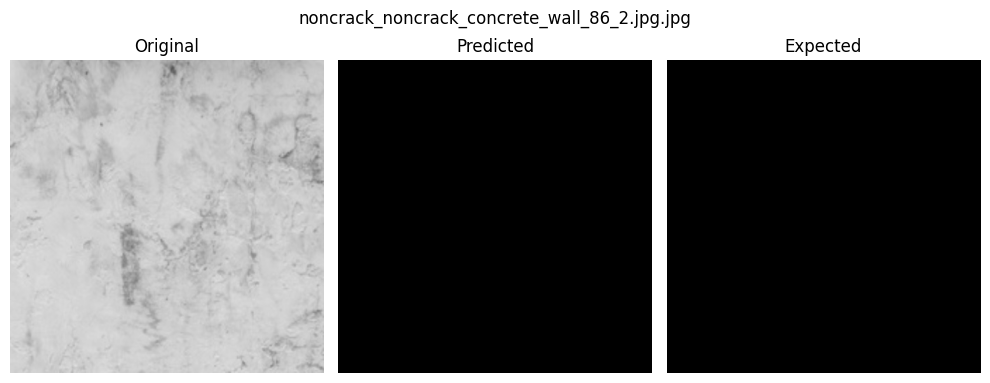

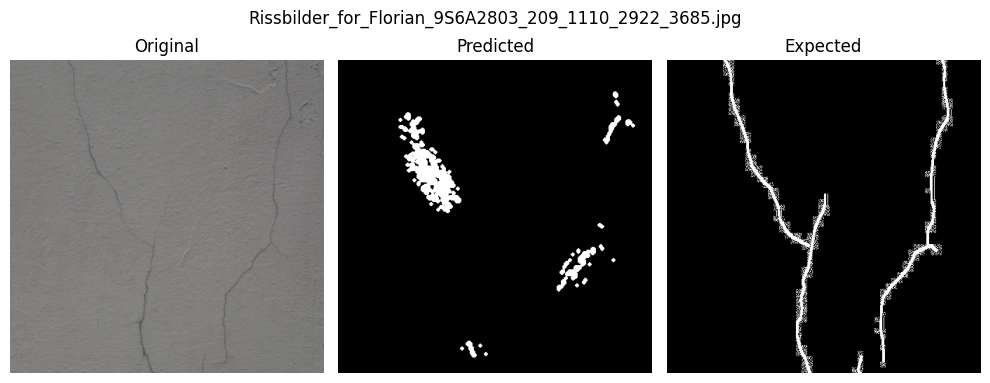

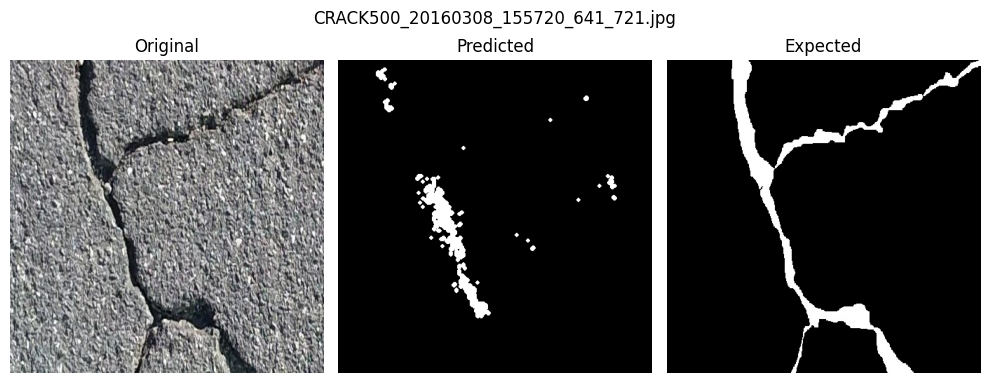

In [ ]:
iou = 0
dice = 0
limit = 10
use_viz = True

indices = np.arange(len(data.test_dataset))
np.random.seed(22)
np.random.shuffle(indices)
indices = indices[:limit]

dataset = Subset(ct_dataset, indices)

def morphology(path, predicted, expected):
    predicted = skimage.morphology.closing(predicted)
    predicted = skimage.morphology.opening(predicted)
    predicted = skimage.morphology.dilation(predicted)
    predicted = predicted > 0
    return path, predicted, expected

def metrics(path, predicted, expected):
    global iou
    global dice
    iou += (1 - loss.iou(predicted, expected))
    dice += (1 - loss.dice(predicted, expected))
    return path, predicted, expected 

def visualize(path, predicted, expected):
    path = Path(path[0])
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    fig.suptitle(path.name, y=0.88)
    
    original = Image.open(path).convert("RGB")
    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # Display the first image (predicted)
    axes[1].imshow(predicted, cmap="gray")
    axes[1].set_title("Predicted")
    axes[1].axis('off')
    
    # Display the second image (expected)
    axes[2].imshow(expected, cmap="gray")
    axes[2].set_title("Expected")
    axes[2].axis('off')
    
    # Show the combined plot
    plt.tight_layout()
    plt.show()
    print()
    return path, predicted, expected 

result = ct.with_postprocessor([
    morphology,
    metrics,
    *([visualize] if use_viz else []),
]).collect(dataset, use_tqdm=not use_viz)

print(f"IOU: {iou / len(dataset)}")
print(f"Dice: {dice / len(dataset)}")